In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from torch.utils.data import DataLoader
# Add the path to utils.py
sys.path.append(r"c:\Document\Serieux\Travail\python_work\cEBNM_torch\py")

# Import utils.py directly
from utils import *
from numerical_routine import *
from distribution_operation import *
from posterior_computation import *

# Set random seed for reproducibility
np.random.seed(1)
torch.manual_seed(1)

batch_size=128
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = DataLoader(mnist_data, batch_size=batch_size , shuffle=True)

# Function to generate y values
def generate_y(t, is_even):
     
    if is_even:        
        if t <0    :
         return  np.random.normal(0, 2 )
        else :
            return np.zeros_like(t)
    else:
        if t>0 :
            return np.random.normal(0, 2 )
        else :
            return  np.zeros_like(t)
        
 
# Custom Dataset class to handle MNIST images and simulated data
class SimulatedMNISTDataset(Dataset):
    def __init__(self, mnist_data, positions, y_values, y_noisy, digits, noise_level, label_type, image_label):
        self.image = mnist_data 
        self.mnist_data = mnist_data
        self.positions = torch.tensor(positions, dtype=torch.float32)
        self.y_values = torch.tensor(y_values, dtype=torch.float32)
        self.y_noisy = torch.tensor(y_noisy, dtype=torch.float32)
        self.digits = torch.tensor(digits, dtype=torch.long)
        self.noise_level = noise_level
        self.label_type = label_type
        self.image_label=image_label
        self.scale = autoselect_scales_mix_norm(
            betahat=np.array(self.y_noisy),
            sebetahat=np.array(self.noise_level)
        )
        
        
       
        self.Lim =torch.tensor(  get_data_loglik_normal(
            betahat=np.array(self.y_noisy),
            sebetahat=np.array(self.noise_level),
            location=0*self.scale,
            scale=self.scale
                     ) , dtype=torch.float32)

    def __len__(self):
        return len(self.mnist_data)

    
    def __getitem__(self, idx):
        image, _ = self.mnist_data[idx]
        position = self.positions[idx]
        y_value = self.y_values[idx]
        y_noisy = self.y_noisy[idx]
        digit = self.digits[idx]
        marginal_log_lik = self.Lim[idx]
        
        return image, digit, position, y_value, y_noisy, marginal_log_lik
    

        
        
        

## Generate the simulated dataset
n_samples = 35000
noise_level = 1
positions = []
y_values = []
digits = []
y_noisy = []
label_type= []
image_label =[]
# Ensure unique indices are used
unique_indices = np.random.choice(len(mnist_data), size=n_samples, replace=False)
filtered_mnist_data = torch.utils.data.Subset(mnist_data, unique_indices)

# Run simulation to generate noisy data
for idx in unique_indices:
    image, label = mnist_data[idx]
    t = np.random.uniform(-0.5, 0.5)
    is_even = label % 2 == 0
    y = generate_y(t, is_even)
    noise = np.random.normal(0, noise_level)
    y_noisy_value = y + noise
    positions.append(t)
    y_values.append(y)
    y_noisy.append(y_noisy_value)
    digits.append(label)
    image_label.append(label)
    label_type.append(is_even)
    
positions = np.array(positions)
y_values = np.array(y_values)
y_noisy = np.array(y_noisy)
digits = np.array(digits)
label_type = np.array(label_type)
image_label = np.array(image_label)
noiseless=y_values
# Create custom dataset with the filtered MNIST dataset and simulated data
simulated_dataset = SimulatedMNISTDataset(
    mnist_data=filtered_mnist_data,
    positions=positions,
    y_values=y_values,
    y_noisy=y_noisy,
    digits=digits,
    noise_level=np.repeat(1, y_noisy.shape[0]),
    label_type=label_type,
    image_label =image_label
)

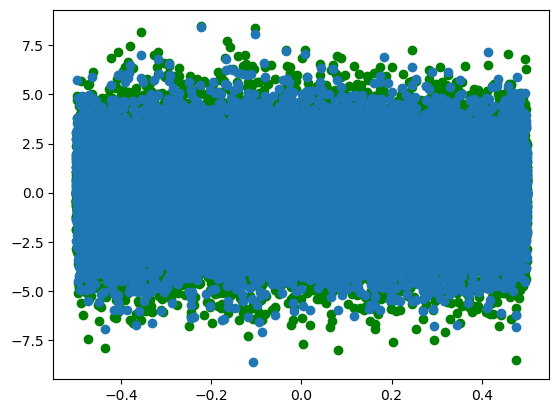

In [2]:
positions =simulated_dataset.positions
y_values = simulated_dataset.y_values
y_noisy = simulated_dataset.y_noisy

plt.scatter(positions, y_noisy, color="green")
plt.scatter(positions,y_values)

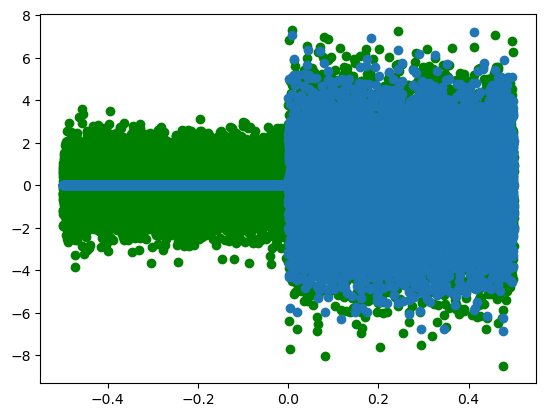

In [3]:
idx=  ~simulated_dataset.label_type
 
plt.scatter(positions[idx], y_noisy[idx], color="green")
plt.scatter(positions[idx],y_values[idx])

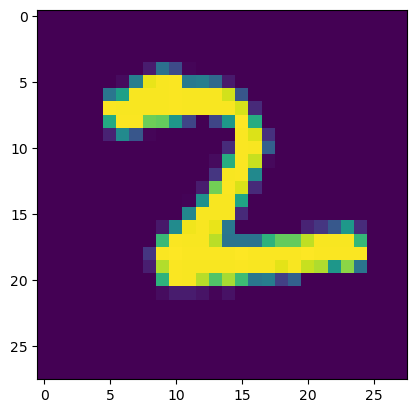

In [4]:
img, label =simulated_dataset.mnist_data[1]
img
plt.imshow(img.squeeze())

In [5]:
 
L_im = simulated_dataset.Lim
print(L_im [0])
scale= autoselect_scales_mix_norm(betahat=np.array(y_noisy),
                             sebetahat=np.repeat(1, y_noisy.shape[0]))
print(get_data_loglik_normal(y_noisy,  location=0*scale,
                             sebetahat=np.repeat(1, y_noisy.shape[0]),
                             scale=scale)[0,])
      
 
n_epoch = 20
batch_size =128

tensor([-9.9796, -9.9424, -9.8327, -9.4215, -8.1232, -5.5716, -3.4243, -2.8679,
        -3.1861, -3.7807])
[-9.97964624 -9.94241715 -9.8327038  -9.42150697 -8.1232224  -5.57158147
 -3.4243323  -2.86791433 -3.18607763 -3.78071764]


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Helper function to calculate the size after the convolutional layers
def calculate_flattened_size(encoder, input_shape):
    """
    Calculate the flattened size after passing an input through the encoder CNN.
    Args:
        encoder: The convolutional encoder network.
        input_shape: Shape of the input (batch_size, channels, height, width).
    Returns:
        The flattened size after the convolutional layers.
    """
    with torch.no_grad():
        x = torch.rand(input_shape)  # Create a dummy input
        x = encoder(x)  # Pass it through the encoder
        return x.view(x.size(0), -1).shape[1]  # Return the flattened size

# CNN-VAE with output as a set of fitted pi values
class CNN_VAE_FittedPi(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, pi_dim):
        super(CNN_VAE_FittedPi, self).__init__()

        # Encoder: convolutional layers to encode the input image
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 14x14 -> 7x7
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 7x7 -> 4x4
            nn.ReLU(),
        )

        # Dynamically calculate the flattened size after the encoder
        flattened_size = calculate_flattened_size(self.encoder, (1, 1, 28, 28))

        # Fully connected layers for mean and log variance of latent space
        self.fc_mu = nn.Linear(flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(flattened_size, latent_dim)

        # Decoder: fully connected layers (with positional input) to output fitted pi values
        self.fc_decode = nn.Sequential(
            nn.Linear(latent_dim + 1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, pi_dim)  # Output matches the number of pi components
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, pos):
        # Concatenate position to the latent vector
        z = torch.cat([z, pos], dim=1)
        x = self.fc_decode(z)
        # Apply softmax to ensure the output sums to 1 (fitted pi)
        return F.softmax(x, dim=1)

    def forward(self, x, pos):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        fitted_pi = self.decode(z, pos)
        return fitted_pi, mu, logvar

# Loss function for the penalized log-likelihood
def vae_loss_function(pred_pi, marginal_log_lik, mu, logvar, penalty=10, epsilon=1e-10):
    """
    Compute the penalized log likelihood function.
    
    Parameters:
    pred_pi (torch.Tensor): A tensor of shape (batch_size, K) corresponding to pi_k for each sample.
    marginal_log_lik (torch.Tensor): A tensor of shape (batch_size, K) corresponding to the log-likelihoods.
    penalty (float): The penalty term for pi[:, 0].
    epsilon (float): Small constant to avoid log of zero or division by zero.

    Returns:
    torch.Tensor: The total loss (negative penalized log likelihood + KL divergence).
    """
    # Reconstruction loss (penalized log-likelihood)
    L_batch = torch.exp(marginal_log_lik)
    inner_sum = torch.sum(pred_pi * L_batch, dim=1)
    inner_sum = torch.clamp(inner_sum, min=epsilon)
    recon_loss = torch.sum(torch.log(inner_sum))

    # Penalty term on the first component of pred_pi
    pi_clamped = torch.clamp(torch.sum(pred_pi[:, 0]), min=epsilon)
    penalized_log_likelihood_value = recon_loss + (penalty - 1) * torch.log(pi_clamped)

    # KL divergence (Kullback-Leibler Divergence)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Return the negative of the penalized log likelihood and the KL divergence
    return -penalized_log_likelihood_value + kl_loss

# Training function
def train_vae(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, digit, pos, y_value, y_noisy, marginal_log_lik) in enumerate(train_loader):
        data, pos, marginal_log_lik = data.to(device), pos.to(device).unsqueeze(1), marginal_log_lik.to(device)
        optimizer.zero_grad()
        pred_pi, mu, logvar = model(data, pos)
        loss = vae_loss_function(pred_pi, marginal_log_lik, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

# Hyperparameters
input_dim = 784  # MNIST images (28x28)
latent_dim = 20
hidden_dim = 400
pi_dim = simulated_dataset.Lim.size()[1]  # Number of components for fitted pi
n_epoch = 20
batch_size = 128

# Main training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_VAE_FittedPi(input_dim, hidden_dim, latent_dim, pi_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_loader = DataLoader(simulated_dataset, batch_size=batch_size, shuffle=True)


Train Epoch: 1 [0/35000 (0%)]	Loss: 1.856730
Train Epoch: 1 [12800/35000 (36%)]	Loss: 1.532902
Train Epoch: 1 [25600/35000 (73%)]	Loss: 1.517252
====> Epoch: 1 Average loss: 1.6444
Train Epoch: 2 [0/35000 (0%)]	Loss: 1.697444
Train Epoch: 2 [12800/35000 (36%)]	Loss: 1.622137
Train Epoch: 2 [25600/35000 (73%)]	Loss: 1.591920
====> Epoch: 2 Average loss: 1.6378
Train Epoch: 3 [0/35000 (0%)]	Loss: 1.556173
Train Epoch: 3 [12800/35000 (36%)]	Loss: 1.640955
Train Epoch: 3 [25600/35000 (73%)]	Loss: 1.752288
====> Epoch: 3 Average loss: 1.6372
Train Epoch: 4 [0/35000 (0%)]	Loss: 1.589741
Train Epoch: 4 [12800/35000 (36%)]	Loss: 1.592709
Train Epoch: 4 [25600/35000 (73%)]	Loss: 1.672319
====> Epoch: 4 Average loss: 1.6369
Train Epoch: 5 [0/35000 (0%)]	Loss: 1.621645
Train Epoch: 5 [12800/35000 (36%)]	Loss: 1.608859
Train Epoch: 5 [25600/35000 (73%)]	Loss: 1.602275
====> Epoch: 5 Average loss: 1.6370
Train Epoch: 6 [0/35000 (0%)]	Loss: 1.621763
Train Epoch: 6 [12800/35000 (36%)]	Loss: 1.566159


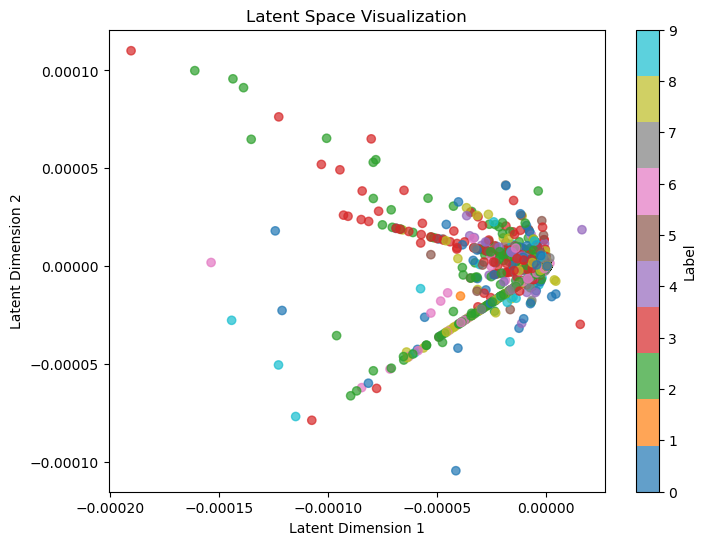

In [7]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader

# Function to visualize the latent space
def visualize_latent_space(model, device, data_loader):
    model.eval()
    all_mu = []
    all_labels = []

    with torch.no_grad():
        for data, digit, pos, _, _, _ in data_loader:
            data, pos = data.to(device), pos.to(device).unsqueeze(1)
            _, mu, _ = model(data, pos)  # Get the latent variable (mu) from the encoder
            all_mu.append(mu.cpu())  # Move the latent variables to CPU for visualization
            all_labels.append(digit.cpu())  # Collect the labels

    # Concatenate all latent variables and labels
    all_mu = torch.cat(all_mu)
    all_labels = torch.cat(all_labels)

    # If latent dimension > 2, reduce it to 2D using PCA for visualization
    latent_dim = all_mu.shape[1]
    if latent_dim > 2:
        pca = PCA(n_components=2)
        reduced_mu = pca.fit_transform(all_mu)
    else:
        reduced_mu = all_mu.numpy()
 
    # Plot the latent space and color it by label
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced_mu[:, 0], reduced_mu[:, 1], c=all_labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, label='Label')
    plt.title('Latent Space Visualization')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.show()

# Main training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_VAE_FittedPi(input_dim, hidden_dim, latent_dim, pi_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_loader = DataLoader(simulated_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(1, n_epoch + 1):
    train_vae(model, device, train_loader, optimizer, epoch)

# After training, visualize the latent space
visualize_latent_space(model, device, train_loader)


C:\Users\willi\AppData\Local\Temp\ipykernel_17556\2141137021.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(reduced_mu[:, 0], reduced_mu[:, 1], c=colors, cmap='tab10', alpha=0.7)


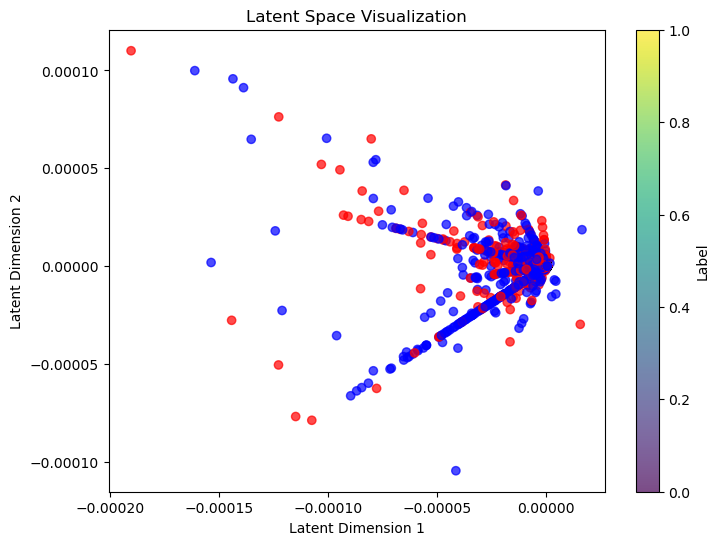

In [8]:
def visualize_latent_space(model, device, data_loader):
    model.eval()
    all_mu = []
    all_labels = []

    with torch.no_grad():
        for data, digit, pos, _, _, _ in data_loader:
            data, pos = data.to(device), pos.to(device).unsqueeze(1)
            _, mu, _ = model(data, pos)  # Get the latent variable (mu) from the encoder
            all_mu.append(mu.cpu())  # Move the latent variables to CPU for visualization
            all_labels.append(digit.cpu())  # Collect the labels

    # Concatenate all latent variables and labels
    all_mu = torch.cat(all_mu)
    all_labels = torch.cat(all_labels)

    # If latent dimension > 2, reduce it to 2D using PCA for visualization
    latent_dim = all_mu.shape[1]
    if latent_dim > 2:
        pca = PCA(n_components=2)
        reduced_mu = pca.fit_transform(all_mu)
    else:
        reduced_mu = all_mu.numpy()
 
    # Plot the latent space and color it by label
    plt.figure(figsize=(8, 6))
    colors = ['blue' if label % 2 == 0 else 'red' for label in all_labels]

    scatter = plt.scatter(reduced_mu[:, 0], reduced_mu[:, 1], c=colors, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, label='Label')
    plt.title('Latent Space Visualization')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.show()



visualize_latent_space(model, device, train_loader)



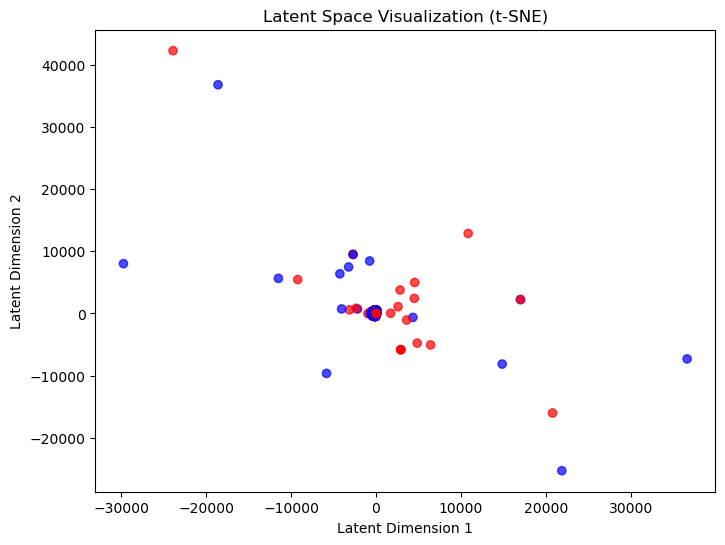

In [9]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch

# Function to visualize the latent space with t-SNE and even/odd coloring
def visualize_latent_space_tsne(model, device, data_loader):
    model.eval()
    all_mu = []
    all_labels = []

    with torch.no_grad():
        for data, digit, pos, _, _, _ in data_loader:
            data, pos = data.to(device), pos.to(device).unsqueeze(1)
            _, mu, _ = model(data, pos)  # Get the latent variable (mu) from the encoder
            all_mu.append(mu.cpu())  # Move the latent variables to CPU for visualization
            all_labels.append(digit.cpu())  # Collect the labels

    # Concatenate all latent variables and labels
    all_mu = torch.cat(all_mu)
    all_labels = torch.cat(all_labels)

    # Reduce to 2D using t-SNE for visualization
    latent_dim = all_mu.shape[1]
    tsne = TSNE(n_components=2)
    reduced_mu = tsne.fit_transform(all_mu)  # Apply t-SNE to latent variables

    # Determine even or odd labels for coloring
    colors = ['blue' if label % 2 == 0 else 'red' for label in all_labels]

    # Plot the latent space and color it based on even/odd labels
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced_mu[:, 0], reduced_mu[:, 1], c=colors, alpha=0.7)
    plt.title('Latent Space Visualization (t-SNE)')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.show()
visualize_latent_space_tsne(model, device, train_loader)


In [10]:
# Function to get the fitted pi values on the training data
def get_fitted_pi(model, device, data_loader):
    model.eval()
    all_pi = []
    all_labels = []

    with torch.no_grad():
        for data, digit, pos, _, _, _ in data_loader:
            data, pos = data.to(device), pos.to(device).unsqueeze(1)
            pred_pi, _, _ = model(data, pos)  # Get the predicted pi from the model
            all_pi.append(pred_pi.detach().cpu())  # Move the fitted pi values to CPU and detach
            all_labels.append(digit.cpu())  # Collect the labels

    # Concatenate all fitted pi values and labels
    all_pi = torch.cat(all_pi)
    all_labels = torch.cat(all_labels)
    
    return all_pi, all_labels

# Call this function after training to get the fitted pi values
fitted_pi, labels = get_fitted_pi(model, device, train_loader)

# Print some of the fitted pi values for the first few samples
print("Fitted pi values for the first few samples:")
print(fitted_pi[:10])
print("Corresponding labels for the first few samples:")
print(labels[:10])


Fitted pi values for the first few samples:
tensor([[6.6852e-01, 1.2957e-10, 7.9940e-11, 9.0993e-11, 4.6912e-11, 3.5645e-10,
         3.3148e-01, 1.0859e-07, 1.4484e-11, 1.2097e-12],
        [6.6153e-01, 4.6496e-08, 3.2314e-08, 3.5210e-08, 2.2899e-08, 1.0118e-07,
         3.3846e-01, 7.7561e-06, 1.2345e-08, 1.6640e-09],
        [6.5547e-01, 2.8612e-07, 1.9791e-07, 2.1133e-07, 1.4662e-07, 5.4614e-07,
         3.4450e-01, 2.2239e-05, 7.5162e-08, 1.4170e-08],
        [6.7312e-01, 2.4960e-09, 1.6456e-09, 1.7750e-09, 1.0826e-09, 6.4429e-09,
         3.2688e-01, 1.0921e-06, 4.7858e-10, 4.7767e-11],
        [6.5727e-01, 2.1598e-07, 1.5682e-07, 1.6583e-07, 1.1567e-07, 4.4608e-07,
         3.4271e-01, 2.1977e-05, 6.3214e-08, 1.0774e-08],
        [6.4965e-01, 1.5207e-06, 1.1061e-06, 1.1614e-06, 8.4374e-07, 2.5969e-06,
         3.5028e-01, 6.6593e-05, 4.5461e-07, 1.0862e-07],
        [6.4515e-01, 4.8848e-06, 3.7534e-06, 3.8992e-06, 2.9674e-06, 8.2201e-06,
         3.5466e-01, 1.6338e-04, 1.7633e-

In [11]:
all_y_noisy =simulated_dataset.y_noisy
est_post = np.zeros(len(all_y_noisy))
i=1
fitted_pi_np = fitted_pi.numpy()
print(simulated_dataset.scale)
print(np.array([all_y_noisy[i]]))
print(np.array([noise_level]))
print(np.log(fitted_pi_np [i, :]))
for i in range(len(all_y_noisy)):
    
    
    est_post[i] = posterior_mean_norm(
        betahat=np.array([all_y_noisy[i]]),
        sebetahat=np.array([noise_level]),
        log_pi=np.log(fitted_pi_np [i, :]),
        scale=simulated_dataset.scale
    ).post_mean


[ 0.          0.06609378  0.13218755  0.2643751   0.5287502   1.05750041
  2.11500082  4.23000163  8.46000327 16.92000653]
[-1.1885052]
[1]
[ -0.41319928 -16.883896   -17.24778    -17.161942   -17.592163
 -16.106373    -1.0833447  -11.767033   -18.209997   -20.214014  ]


C:\Users\willi\AppData\Local\Temp\ipykernel_17556\1954664198.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  est_post[i] = posterior_mean_norm(


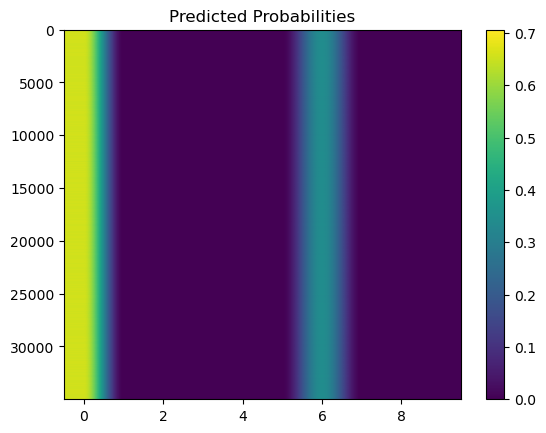

In [12]:
plt.imshow(fitted_pi, aspect='auto')
plt.title('Predicted Probabilities')
plt.colorbar()


In [13]:
import sys
import os
import matplotlib.pyplot as plt

# Add the path to utils.py
sys.path.append(r"c:\Document\Serieux\Travail\python_work\cEBNM_torch\py")
from distribution_operation import *
from utils import *
from numerical_routine import *
from posterior_computation import *
from ash import *
print(np.repeat(noise_level, y_noisy.shape[0]))
betahat =  np.array(simulated_dataset.y_noisy )

sebetahat =  np.repeat(noise_level, betahat.shape[0])
print(sebetahat)
res= ash(betahat=betahat,
         sebetahat= sebetahat)

[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]


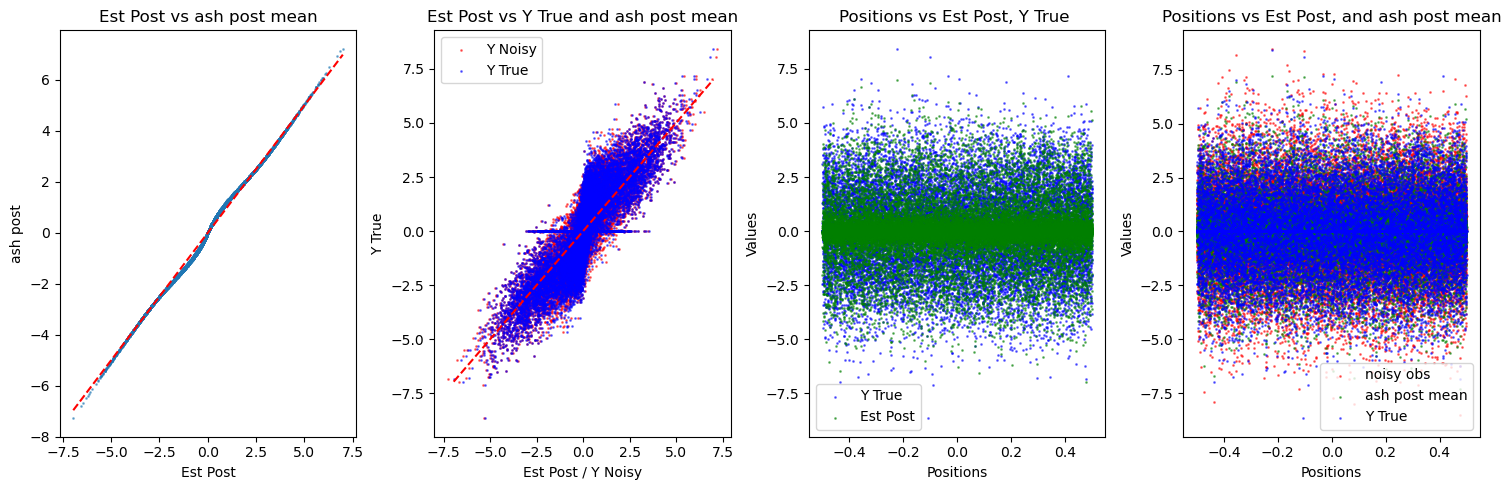

TypeError: mean() received an invalid combination of arguments - got (axis=NoneType, dtype=NoneType, out=NoneType, ), but expected one of:
 * (*, torch.dtype dtype)
 * (tuple of ints dim, bool keepdim, *, torch.dtype dtype)
 * (tuple of names dim, bool keepdim, *, torch.dtype dtype)


In [14]:

idx=  ~simulated_dataset.label_type
 
# Plotting
plt.figure(figsize=(15, 5))

# Plot 1: Est Post vs Y Noisy
plt.subplot(1, 4, 1)
plt.scatter(est_post ,res.post_mean , alpha=0.5, s=1)
plt.title('Est Post vs ash post mean')
plt.xlabel('Est Post')
plt.ylabel('ash post')
plt.plot([min(est_post), max(est_post)], [min(est_post), max(est_post)], 'r--')

# Plot 2: Est Post vs Y True
plt.subplot(1, 4, 2)
plt.scatter(res.post_mean , y_values , alpha=0.5, s=1, label='Y Noisy', color='red')

plt.scatter(est_post , y_values , alpha=0.5, s=1, label='Y True', color='blue')
plt.title('Est Post vs Y True and ash post mean')
plt.xlabel('Est Post / Y Noisy')
plt.ylabel('Y True')
plt.legend()
plt.plot([min(est_post), max(est_post)], [min(est_post), max(est_post)], 'r--')

# Plot 3: Positions vs Est Post, Y True, and Y Noisy
plt.subplot(1, 4, 3) 

plt.scatter(positions , y_values , alpha=0.5, s=1, label='Y True', color='blue')
plt.scatter(positions , est_post , alpha=0.5, s=1, label='Est Post', color='green') 
plt.title('Positions vs Est Post, Y True ')
plt.xlabel('Positions')
plt.ylabel('Values')
plt.legend()

plt.subplot(1, 4, 4)

plt.scatter(positions ,all_y_noisy , alpha=0.5, s=1, label='noisy obs', color='red')
plt.scatter(positions ,res.post_mean , alpha=0.5, s=1, label='ash post mean', color='green')
plt.scatter(positions , y_values , alpha=0.5, s=1, label='Y True', color='blue') 
plt.title('Positions vs Est Post, and ash post mean')
plt.xlabel('Positions')
plt.ylabel('Values')
plt.legend()


plt.tight_layout()
plt.show()

 
# Calculate and print MSE

# Calculate and print MSE
mse_noisy = np.mean((y_values  - y_noisy)**2)
mse_est = np.mean((est_post  - y_values )**2)

mse_ash  = np.mean((res.post_mean -y_values )**2)
print(f"\nMean Squared Error:")
print(f"MSE (Y Noisy vs Y True): {mse_noisy:.4f}")
print(f"MSE (Est Post vs Y True): {mse_est:.4f}")

print(f"MSE (Est Post vs Y True): {mse_ash:.4f}")

In [ ]:

idx=  ~simulated_dataset.label_type
 
# Plotting
plt.figure(figsize=(15, 5))

# Plot 1: Est Post vs Y Noisy
plt.subplot(1, 4, 1)
plt.scatter(est_post[idx],res.post_mean[idx], alpha=0.5, s=1)
plt.title('Est Post vs ash post mean')
plt.xlabel('Est Post')
plt.ylabel('ash post')
plt.plot([min(est_post), max(est_post)], [min(est_post), max(est_post)], 'r--')

# Plot 2: Est Post vs Y True
plt.subplot(1, 4, 2)
plt.scatter(res.post_mean[idx], y_values[idx], alpha=0.5, s=1, label='Y Noisy', color='red')

plt.scatter(est_post[idx], y_values[idx], alpha=0.5, s=1, label='Y True', color='blue')
plt.title('Est Post vs Y True and ash post mean')
plt.xlabel('Est Post / Y Noisy')
plt.ylabel('Y True')
plt.legend()
plt.plot([min(est_post), max(est_post)], [min(est_post), max(est_post)], 'r--')

# Plot 3: Positions vs Est Post, Y True, and Y Noisy
plt.subplot(1, 4, 3) 

plt.scatter(positions[idx], y_values[idx], alpha=0.5, s=1, label='Y True', color='blue')
plt.scatter(positions[idx], est_post[idx], alpha=0.5, s=1, label='Est Post', color='green') 
plt.title('Positions vs Est Post, Y True ')
plt.xlabel('Positions')
plt.ylabel('Values')
plt.legend()

plt.subplot(1, 4, 4)

plt.scatter(positions[idx],all_y_noisy[idx], alpha=0.5, s=1, label='noisy obs', color='red')
plt.scatter(positions[idx],res.post_mean[idx], alpha=0.5, s=1, label='ash post mean', color='green')
plt.scatter(positions[idx], y_values[idx], alpha=0.5, s=1, label='Y True', color='blue') 
plt.title('Positions vs Est Post, and ash post mean')
plt.xlabel('Positions')
plt.ylabel('Values')
plt.legend()


plt.tight_layout()
plt.show()

 
# Calculate and print MSE

# Calculate and print MSE
mse_noisy = np.mean((y_values[idx] - y_noisy[idx])**2)
mse_est = np.mean((est_post[idx] - y_values[idx])**2)

mse_ash  = np.mean((res.post_mean[idx] -y_values[idx])**2)
print(f"\nMean Squared Error:")
print(f"MSE (Y Noisy vs Y True): {mse_noisy:.4f}")
print(f"MSE (Est Post vs Y True): {mse_est:.4f}")

print(f"MSE (Est Post vs Y True): {mse_ash:.4f}")

In [ ]:
np.exp( - np.arange(0,K-1) )/ np.sum( np.exp( - np.arange(0,K-1) ))

